**Task 2** | solve the PDE | u_xx(x, t) + k * u(x, t) * c(x), x, t ε [0,1] and c(x) = sin(-x**2)

In [ ]:
import torch
import torch.nn as nn
import torch.autograd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Net1D(nn.Module):
    def __init__(self, input_dimensions, n_hidden_layers, neurons, output_dimensions):
        super().__init__()
        self.input_dimensions = input_dimensions
        self.n_hidden_layers = n_hidden_layers
        self.neurons = neurons
        self.output_dimensions = output_dimensions
        self.activation = nn.Tanh()

        #layers
        self.input_layer = nn.Linear(self.input_dimensions, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimensions)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [ ]:
def compute_loss(net, x, t):
    xt = torch.cat([x, t], dim=1)
    xt.requires_grad = True

    u = net(xt)
    grads = torch.autograd.grad(u, xt, create_graph=True, grad_outputs=torch.ones_like(u))
    # Extract the gradient with respect to t (the second input variable)
    u_t = grads[0][:, [1]]
    u_x = grads[0][:, [0]]
    u_xx = torch.autograd.grad(u_x, xt, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, [0]]

    # PDE Loss
    pde_loss = (u_t - u_xx - u * torch.sin(-x ** 2)).pow(2).mean()

    # Boundary condition losses
    # Left boundary: Neumann condition (du/dx = 0 at x=0)
    x_left_boundary = torch.zeros_like(t)
    xt_left_boundary = torch.cat([x_left_boundary, t], dim=1)
    xt_left_boundary.requires_grad = True # Need gradients with respect to this boundary input

    u_left_boundary = net(xt_left_boundary)
    # Compute spatial gradient at the left boundary
    u_x_left_boundary = torch.autograd.grad(u_left_boundary, xt_left_boundary, create_graph=True, grad_outputs=torch.ones_like(u_left_boundary))[0][:, [0]]
    neumann_loss = u_x_left_boundary.pow(2).mean() # Penalize deviation from zero gradient

    # Right boundary: Dirichlet condition (u = 1 at x=1)
    x_right_boundary = torch.ones_like(t)
    xt_right_boundary = torch.cat([x_right_boundary, t], dim=1)
    u_right_boundary = net(xt_right_boundary)
    dirichlet_loss = (u_right_boundary - 1.0).pow(2).mean() # Penalize deviation from 1

    bc_loss = neumann_loss + dirichlet_loss

    # Initial condition loss
    u_init = net(torch.cat([x, torch.zeros_like(x)], dim=1))
    ic_loss = (u_init - torch.sin(np.pi * x)).pow(2).mean()

    # Total Loss
    loss = pde_loss + bc_loss + ic_loss

    return loss

In [ ]:
# Training

def pinn_training(time_point: int):

    #net = Net1D(2, 4, 20, 1)
    #optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    training_steps = [0, 5000, 10000, 30000]
    solutions = []

    for steps in training_steps:
        # Re-initialize network and optimizer for each set of training steps
        net = Net1D(2, 2, 30, 1)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        print(f"Training for {steps} steps...")
        for epoch in range(steps):
            optimizer.zero_grad()
            x_rand = torch.rand(10, 1)
            t_rand = torch.rand(10, 1)
            loss = compute_loss(net=net, x=x_rand, t=t_rand)
            loss.backward()
            optimizer.step()

            # Print loss every 200 iterations
            if (epoch + 1) % 5000 == 0:
                print(f'Epoch [{epoch+1}/{steps}], Loss: {loss.item():.6f}')

        # Store solution

        x = torch.linspace(0, 1, 100).reshape(-1, 1)
        t = torch.tensor([[time_point]])
        xt = torch.cat([x, t.repeat(100, 1)], dim=1)
        u_pred = net(xt).detach().numpy()
        solutions.append(u_pred)

    print(f"Training for {steps} steps complete.")
    print(f"Total loss: {loss.item()}")
    return solutions, training_steps

Training for 0 steps...
Training for 5000 steps...
Epoch [5000/5000], Loss: 0.112101
Training for 10000 steps...
Epoch [5000/10000], Loss: 0.135906
Epoch [10000/10000], Loss: 0.173444
Training for 30000 steps...
Epoch [5000/30000], Loss: 0.097153
Epoch [10000/30000], Loss: 0.070415
Epoch [15000/30000], Loss: 0.129405
Epoch [20000/30000], Loss: 0.049043
Epoch [25000/30000], Loss: 0.119773
Epoch [30000/30000], Loss: 0.035530
Training for 30000 steps complete.
Total loss: 0.03552991896867752


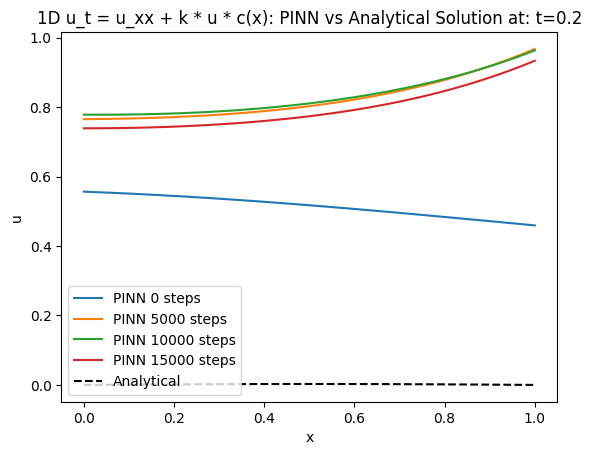

In [ ]:
time_point = 0.2
pinn_training(time_point)

for i, steps in enumerate(training_steps):
    plt.plot(x.numpy(), solutions[i], label=f"PINN {steps} steps")


plt.plot(x.numpy(), u_true, 'k--', label="Analytical")
plt.legend()
plt.title(f"1D u_t = u_xx + k * u * c(x): PINN vs Analytical Solution at: t={time_point}")
plt.xlabel("x")
plt.ylabel("u")
plt.show()